<b>Important:</b> Save prepared/modified datasets locally to <code>../data/prepared/</code>


<b>Important:</b> We only apply outlier treatment to the training set.


In [3]:
import sys
import pandas as pd
import numpy as np
sys.path.insert(1, '../../../../utils')
from numpy import ndarray, array
from pandas import read_csv, DataFrame, Series
from matplotlib.pyplot import figure, savefig, show, subplots
from dslabs_functions import *
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier


In [4]:
# Load data
train_filename = "../../data/prepared/mvi/flight_train_mvi.csv"
test_filename = "../../data/prepared/mvi/flight_test_mvi.csv"
train_data: DataFrame = read_csv(train_filename, na_values="")
test_data: DataFrame = read_csv(test_filename, na_values="")

print(train_data.shape, test_data.shape)

(140000, 182) (60000, 182)


In [5]:
# Numeric vars for outlier analysis (exclude target)
target = "Cancelled"
vars_types   = get_variable_types(train_data)
numeric_vars = vars_types["numeric"].copy()
if target in numeric_vars:
    numeric_vars.remove(target)

print("Numeric vars for outlier handling:", len(numeric_vars))

Numeric vars for outlier handling: 32


In [6]:
# Thresholds for outlier detection
TUNED_NR_STDEV   = 10      
TUNED_IQR_FACTOR = 10 

       ArrTimeBlk_cos  ArrTimeBlk_sin     CRSArrTime     CRSDepTime  \
count   140000.000000   140000.000000  140000.000000  140000.000000   
mean        -0.074241       -0.030266    1487.698179    1324.740643   
std          0.692821        0.716823     514.001183     488.233904   
min         -1.000000       -0.985000       1.000000       1.000000   
25%         -0.766000       -0.643000    1105.000000     915.000000   
50%         -0.174000        0.000000    1512.000000    1315.000000   
75%          0.500000        0.643000    1919.000000    1730.000000   
max          1.000000        0.985000    2359.000000    2359.000000   

       CRSElapsedTime  DOT_ID_Marketing_Airline  DOT_ID_Operating_Airline  \
count   140000.000000             140000.000000             140000.000000   
mean       142.302721              19832.939343              19995.939879   
std         71.713986                275.914648                376.857720   
min          5.000000              19393.000000     

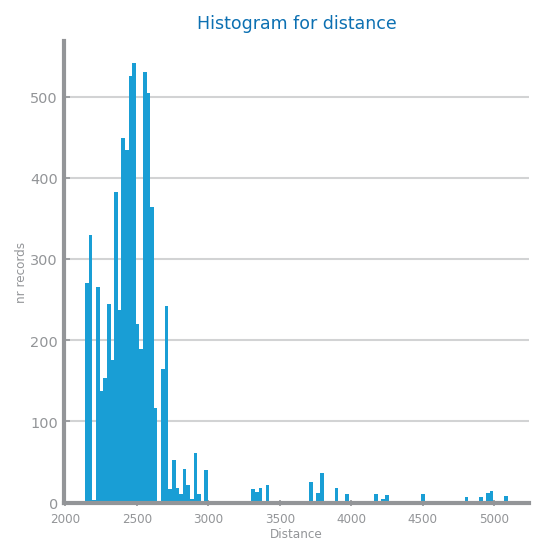

ArrTimeBlk_0 invalid values: 0
ArrTimeBlk_1 invalid values: 0
ArrTimeBlk_10 invalid values: 0
ArrTimeBlk_11 invalid values: 0
ArrTimeBlk_12 invalid values: 0
ArrTimeBlk_13 invalid values: 0
ArrTimeBlk_14 invalid values: 0
ArrTimeBlk_15 invalid values: 0
ArrTimeBlk_16 invalid values: 0
ArrTimeBlk_17 invalid values: 0
ArrTimeBlk_18 invalid values: 0
ArrTimeBlk_2 invalid values: 0
ArrTimeBlk_3 invalid values: 0
ArrTimeBlk_4 invalid values: 0
ArrTimeBlk_5 invalid values: 0
ArrTimeBlk_6 invalid values: 0
ArrTimeBlk_7 invalid values: 0
ArrTimeBlk_8 invalid values: 0
ArrTimeBlk_9 invalid values: 0
ArrTimeBlk_cos invalid values: 76493
ArrTimeBlk_sin invalid values: 64947
CRSArrTime invalid values: 0
CRSDepTime invalid values: 0
CRSElapsedTime invalid values: 0
DepTimeBlk_0 invalid values: 0
DepTimeBlk_1 invalid values: 0
DepTimeBlk_10 invalid values: 0
DepTimeBlk_11 invalid values: 0
DepTimeBlk_12 invalid values: 0
DepTimeBlk_13 invalid values: 0
DepTimeBlk_14 invalid values: 0
DepTimeBlk_15 i

In [7]:
# Quick sanitiy check (is outliers analysis needed?)
print(train_data[numeric_vars].describe())

# Check for impossible values in distance
if 'Distance' in train_data.columns:
    print(f"\nDistance range: {train_data['Distance'].min()} - {train_data['Distance'].max()}")
    print(f"Negative distances: {(train_data['Distance'] < 0).sum()}")
    
    # Print histogram of 5% largest distances
    largest_distances = train_data["Distance"].dropna().quantile(0.95)
    fig, axs = subplots(1, 1, figsize=(HEIGHT, HEIGHT), squeeze=False)
    set_chart_labels(
        axs[0, 0],
        title=f"Histogram for distance",
        xlabel="Distance",
        ylabel="nr records",
    )
    axs[0,0].hist(train_data["Distance"].dropna().loc[train_data["Distance"] >= largest_distances].values, "auto")
    show()

# Check time variables are in valid range (0-2400)
time_vars = [col for col in train_data.columns if 'Time' in col]
for var in time_vars:
    invalid = ((train_data[var] < 0) | (train_data[var] > 2400)).sum()
    print(f"{var} invalid values: {invalid}")

### Would already conclude here that there are no outliers...

In [8]:
def determine_outlier_thresholds_for_var(
    summary5: Series,
    std_based: bool,
    threshold: float,
) -> tuple[float, float]:
    """Return (top, bottom) outlier thresholds for a variable."""
    if std_based:
        std = threshold * summary5["std"]
        top = summary5["mean"] + std
        bottom = summary5["mean"] - std
    else:
        iqr = threshold * (summary5["75%"] - summary5["25%"])
        top = summary5["75%"] + iqr
        bottom = summary5["25%"] - iqr
    return top, bottom


def count_outliers(
    data: DataFrame,
    numeric: list[str],
    nrstdev: int,
    iqrfactor: float,
) -> dict[str, list[int]]:
    """
    Count outliers per numeric variable using:
      - std-based thresholds (nrstdev)
      - IQR-based thresholds (iqrfactor)
    Returns: {"iqr": [...], "stdev": [...]}
    """
    outliers_iqr: list[int] = []
    outliers_stdev: list[int] = []
    summary5: DataFrame = data[numeric].describe()

    for var in numeric:
        # std-based
        top, bottom = determine_outlier_thresholds_for_var(
            summary5[var], std_based=True, threshold=nrstdev
        )
        n_std = data[(data[var] > top) | (data[var] < bottom)].shape[0]
        outliers_stdev.append(n_std)

        # IQR-based
        top, bottom = determine_outlier_thresholds_for_var(
            summary5[var], std_based=False, threshold=iqrfactor
        )
        n_iqr = data[(data[var] > top) | (data[var] < bottom)].shape[0]
        outliers_iqr.append(n_iqr)

    return {"iqr": outliers_iqr, "stdev": outliers_stdev}

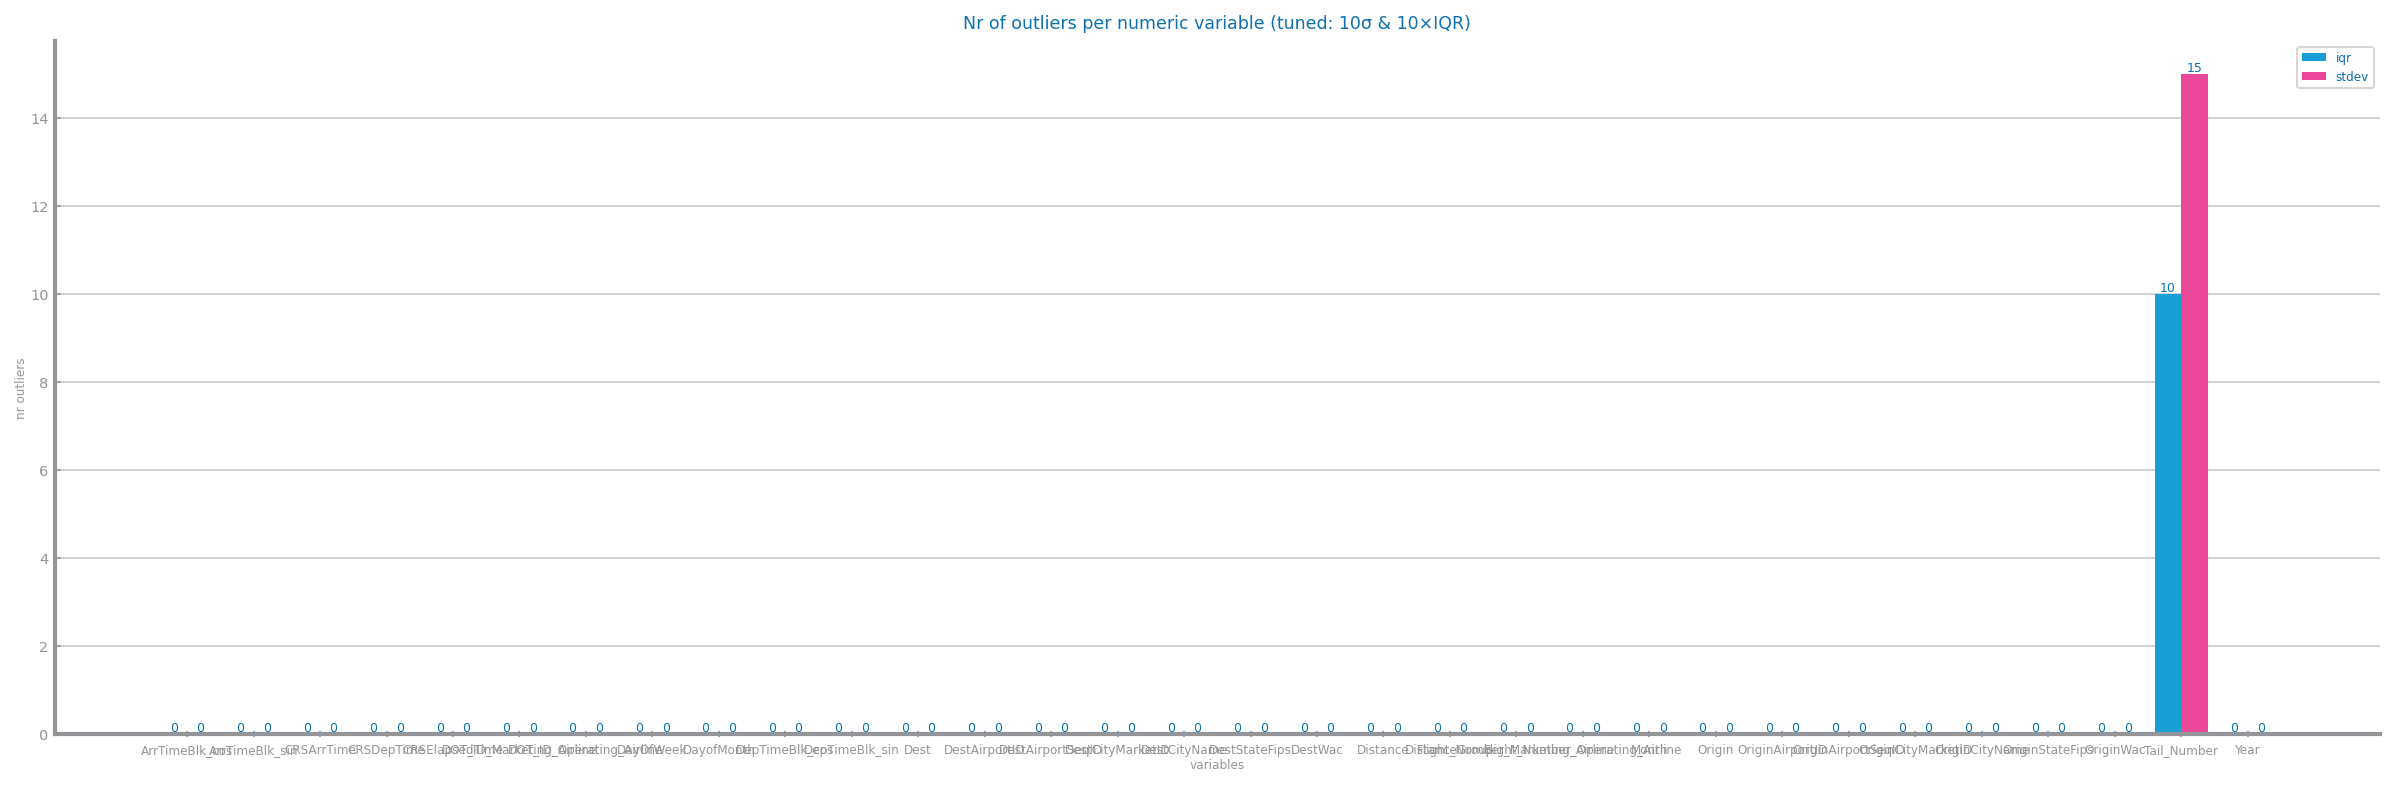

In [9]:
file_tag = "flight_mvi1"

if numeric_vars:
    outliers_tuned = count_outliers(
        train_data,
        numeric=numeric_vars,
        nrstdev=TUNED_NR_STDEV,
        iqrfactor=TUNED_IQR_FACTOR,
    )

    figure(figsize=(20, 6))
    plot_multibar_chart(
        numeric_vars,
        outliers_tuned,
        title=(
            f"Nr of outliers per numeric variable "
            f"(tuned: {TUNED_NR_STDEV}σ & {TUNED_IQR_FACTOR}×IQR)"
        ),
        xlabel="variables",
        ylabel="nr outliers",
        percentage=False,
    )
    show()
else:
    print("There are no numeric variables.")



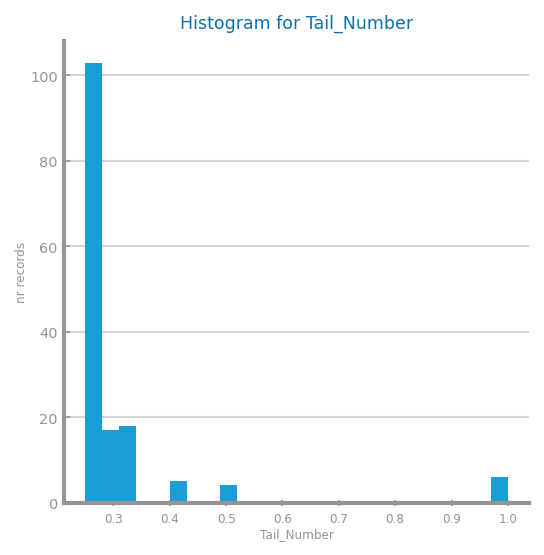

In [10]:
# Tail_Number outliers (Target encoded, so 1 = always cancelled, 0 = never cancelled)
largest_distances = train_data["Tail_Number"].dropna().quantile(0.999)
fig, axs = subplots(1, 1, figsize=(HEIGHT, HEIGHT), squeeze=False)
set_chart_labels(
    axs[0, 0],
    title=f"Histogram for Tail_Number",
    xlabel="Tail_Number",
    ylabel="nr records",
)
axs[0,0].hist(train_data["Tail_Number"].dropna().loc[train_data["Tail_Number"] >= largest_distances].values, "auto")
show()

In [11]:
# Print variables with outliers
def list_variables_with_outliers(
    numeric_vars: list[str],
    outlier_dict: dict[str, list[int]]
) -> list[str]:
    print(f"{'Variable':40s} | {'IQR Outliers':12s} | {'StDev Outliers':14s}")
    print("-" * 75)
    
    vars_with_outliers = []
    
    for i, var in enumerate(numeric_vars):
        n_iqr   = outlier_dict["iqr"][i]
        n_stdev = outlier_dict["stdev"][i]

        if n_iqr > 0 or n_stdev > 0:
            print(f"{var:40s} | {n_iqr:<12d} | {n_stdev:<14d}")
            vars_with_outliers.append(var)
    
    return vars_with_outliers

OUTLIER_VARS = list_variables_with_outliers(numeric_vars, outliers_tuned)

Variable                                 | IQR Outliers | StDev Outliers
---------------------------------------------------------------------------
Tail_Number                              | 10           | 15            


# Outliers Method 1 (Drop)

In [12]:
def outlier_drop(
    train: DataFrame,
    test: DataFrame,
    outlier_vars: list[str],
    std_based: bool = False,          # False → use IQR-based thresholds
    nrstdev: float = TUNED_NR_STDEV,
    iqrfactor: float = TUNED_IQR_FACTOR,
) -> tuple[DataFrame, DataFrame]:
    train = train.copy()
    test  = test.copy()

    numeric_cols = train.select_dtypes(include="number").columns.tolist()
    vars_to_use  = [v for v in outlier_vars if v in numeric_cols]

    if not vars_to_use:
        print("No outlier variables found in numeric columns. Returning unchanged.")
        return train, test

    summary5 = train[vars_to_use].describe()

    # mask only for TRAIN; test is left untouched
    mask_train = DataFrame(True, index=train.index, columns=["keep"])["keep"]

    for var in vars_to_use:
        top, bottom = determine_outlier_thresholds_for_var(
            summary5[var],
            std_based=std_based,
            threshold=(nrstdev if std_based else iqrfactor),
        )
        mask_train &= (train[var] <= top) & (train[var] >= bottom)

    train_out = train[mask_train].copy()
    test_out  = test.copy()  # NO DROPPING IN TEST

    print(f"[outlier_drop] Train: {len(train)} → {len(train_out)}")
    print(f"[outlier_drop] Test:  {len(test)} → {len(test_out)} (unchanged rows)")

    return train_out, test_out

# Outlier Method 2 (Truncate)

In [13]:
def outlier_truncate(
    train: DataFrame,
    test: DataFrame,
    outlier_vars: list[str],
    std_based: bool = False,          # False → use IQR-based thresholds
    nrstdev: float = TUNED_NR_STDEV,
    iqrfactor: float = TUNED_IQR_FACTOR,
) -> tuple[DataFrame, DataFrame]:
    
    train = train.copy()
    test  = test.copy()

    numeric_cols = train.select_dtypes(include="number").columns.tolist()
    vars_to_use  = [v for v in outlier_vars if v in numeric_cols]

    if not vars_to_use:
        print("No outlier variables found in numeric columns. Returning unchanged.")
        return train, test

    summary5 = train[vars_to_use].describe()

    for var in vars_to_use:
        top, bottom = determine_outlier_thresholds_for_var(
            summary5[var],
            std_based=std_based,
            threshold=(nrstdev if std_based else iqrfactor),
        )

        # truncate / clip ONLY TRAIN to [bottom, top]
        train[var] = train[var].clip(lower=bottom, upper=top)
        # test[var] left as-is

    print(f"[outlier_truncate] Applied truncation to TRAIN only: {vars_to_use}")

    return train, test

# Outlier Method 3 - Keep All

In [14]:
def outlier_none(train: DataFrame, test: DataFrame) -> tuple[DataFrame, DataFrame]:
    return train.copy(), test.copy()

# Evaluation

In [15]:
train_none,  test_none  = outlier_none(train_data, test_data)
train_drop,  test_drop  = outlier_drop(
    train_data, test_data, OUTLIER_VARS,
    std_based=False, nrstdev=TUNED_NR_STDEV, iqrfactor=TUNED_IQR_FACTOR
)
train_trunc, test_trunc = outlier_truncate(
    train_data, test_data, OUTLIER_VARS,
    std_based=False, nrstdev=TUNED_NR_STDEV, iqrfactor=TUNED_IQR_FACTOR
)

print("NONE  shapes:",  train_none.shape,  test_none.shape)
print("DROP  shapes:",  train_drop.shape,  test_drop.shape)
print("TRUNC shapes:", train_trunc.shape, test_trunc.shape)

[outlier_drop] Train: 140000 → 139990
[outlier_drop] Test:  60000 → 60000 (unchanged rows)
[outlier_truncate] Applied truncation to TRAIN only: ['Tail_Number']
NONE  shapes: (140000, 182) (60000, 182)
DROP  shapes: (139990, 182) (60000, 182)
TRUNC shapes: (140000, 182) (60000, 182)


In [61]:
file_tag_none  = "flight_outliers_none"
file_tag_drop  = "flight_outliers_drop"
file_tag_trunc = "flight_outliers_trunc"

cols_to_drop = ["FlightDate",]


train_none_eval = train_none.drop(columns=cols_to_drop, errors="ignore").copy()
test_none_eval  = test_none.drop(columns=cols_to_drop, errors="ignore").copy()

train_drop_eval = train_drop.drop(columns=cols_to_drop, errors="ignore").copy()
test_drop_eval  = test_drop.drop(columns=cols_to_drop, errors="ignore").copy()

train_trunc_eval = train_trunc.drop(columns=cols_to_drop, errors="ignore").copy()
test_trunc_eval  = test_trunc.drop(columns=cols_to_drop, errors="ignore").copy()

# ensure target is int
for df in [
    train_none_eval,  test_none_eval,
    train_drop_eval,  test_drop_eval,
    train_trunc_eval, test_trunc_eval,
]:
    df[target] = df[target].astype(int)


def evaluate_approach(
    train: DataFrame,
    test: DataFrame,
    target: str = "Cancelled",
    metric: str = "recall",
) -> dict[str, list[float]]:
    trn = train.copy()
    tst = test.copy()

    trnY = trn.pop(target).values
    trnX: ndarray = trn.values
    tstY = tst.pop(target).values
    tstX: ndarray = tst.values

    eval_dict: dict[str, list[float]] = {}

    eval_NB  = run_NB(trnX, trnY, tstX, tstY, metric=metric)
    eval_KNN = run_KNN(trnX, trnY, tstX, tstY, metric=metric)

    if eval_NB and eval_KNN:
        for met in CLASS_EVAL_METRICS:
            eval_dict[met] = [eval_NB[met], eval_KNN[met]]

    return eval_dict


def print_eval_table(eval_dict: dict[str, list[float]], label: str):
    print(f"{'Metric':12s} | {'NB':>10s} | {'KNN':>10s}")
    print("-" * 40)
    for metric, vals in eval_dict.items():
        nb, knn = vals
        print(f"{metric:12s} | {nb:10.4f} | {knn:10.4f}")
    print()


=== OUTLIERS EVALUATION (NB + KNN) ===
Couldn't run MultinomialNB
Metric       |         NB |        KNN
----------------------------------------
accuracy     |     0.9318 |     0.9496
recall       |     0.0977 |     0.0575
precision    |     0.0458 |     0.0447
auc          |     0.5247 |     0.5141
f1           |     0.0624 |     0.0503



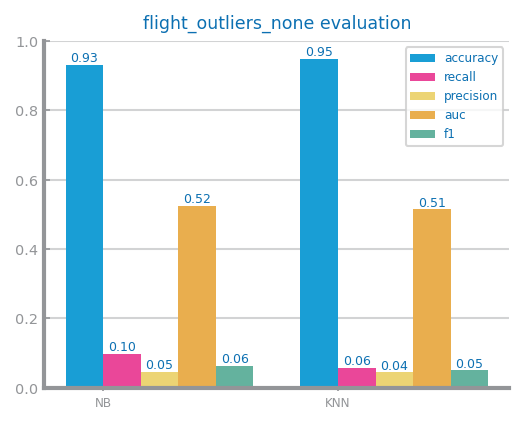

Couldn't run MultinomialNB
Metric       |         NB |        KNN
----------------------------------------
accuracy     |     0.9315 |     0.9497
recall       |     0.0977 |     0.0575
precision    |     0.0455 |     0.0447
auc          |     0.5245 |     0.5142
f1           |     0.0621 |     0.0503



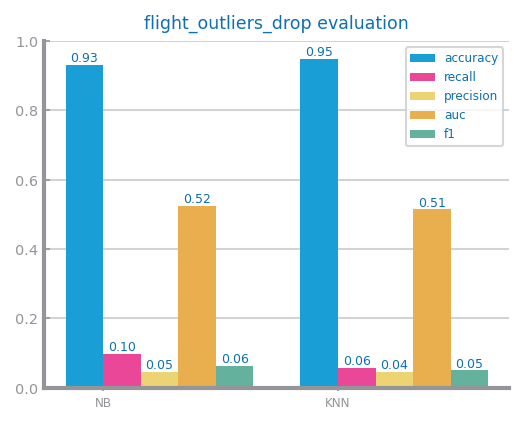

Couldn't run MultinomialNB
Metric       |         NB |        KNN
----------------------------------------
accuracy     |     0.9318 |     0.9496
recall       |     0.0977 |     0.0575
precision    |     0.0458 |     0.0447
auc          |     0.5247 |     0.5141
f1           |     0.0624 |     0.0503



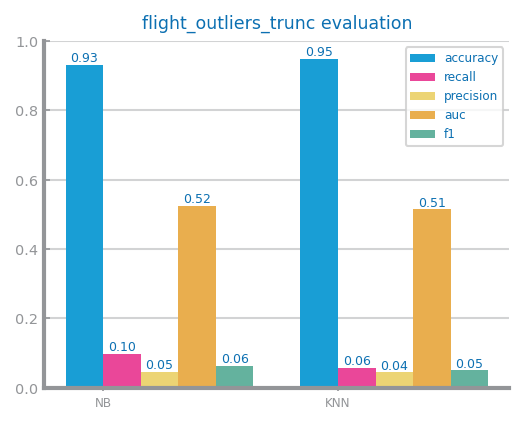

In [62]:
# NONE (baseline)
figure()
eval_none = evaluate_approach(
    train_none_eval.copy(),
    test_none_eval.copy(),
    target=target,
    metric="recall",
)
print_eval_table(eval_none, "NONE (baseline)")
plot_multibar_chart(
    ["NB", "KNN"],
    eval_none,
    title=f"{file_tag_none} evaluation",
    percentage=True,
)
# savefig(f"../../charts/lab3_preparation/{file_tag_none}_NB_KNN_recall_eval.png")
show()

# DROP OUTLIERS 
figure()
eval_drop = evaluate_approach(
    train_drop_eval.copy(),
    test_drop_eval.copy(),
    target=target,
    metric="recall",
)
print_eval_table(eval_drop, "DROP OUTLIERS")
plot_multibar_chart(
    ["NB", "KNN"],
    eval_drop,
    title=f"{file_tag_drop} evaluation",
    percentage=True,
)
# savefig(f"../../charts/lab3_preparation/{file_tag_drop}_NB_KNN_recall_eval.png")
show()

# TRUNCATE OUTLIERS
figure()
eval_trunc = evaluate_approach(
    train_trunc_eval.copy(),
    test_trunc_eval.copy(),
    target=target,
    metric="recall",
)
print_eval_table(eval_trunc, "TRUNCATE OUTLIERS")
plot_multibar_chart(
    ["NB", "KNN"],
    eval_trunc,
    title=f"{file_tag_trunc} evaluation",
    percentage=True,
)
# savefig(f"../../charts/lab3_preparation/{file_tag_trunc}_NB_KNN_recall_eval.png")
show()

In [22]:
file_tag    = "flight_outliers_none"
target      = "Cancelled"
eval_metric = "recall"

# Use the BEST outlier strategy → NONE
train_df = train_none_eval.copy()
test_df  = test_none_eval.copy()

trnY = train_df[target].values
tstY = test_df[target].values

trnX = train_df.drop(columns=[target]).values
tstX = test_df.drop(columns=[target]).values

labels = sorted(list(set(trnY) | set(tstY)))
print(f"Train#={len(trnX)}  Test#={len(tstX)}")
print(f"Labels={labels}")

Train#=140000  Test#=60000
Labels=[np.int64(0), np.int64(1)]


<Figure size 600x450 with 0 Axes>

Best NB params: {'name': 'MultinomialNB', 'metric': 'recall', 'params': (), 'recall': 0.532150776053215}


<Figure size 600x450 with 0 Axes>

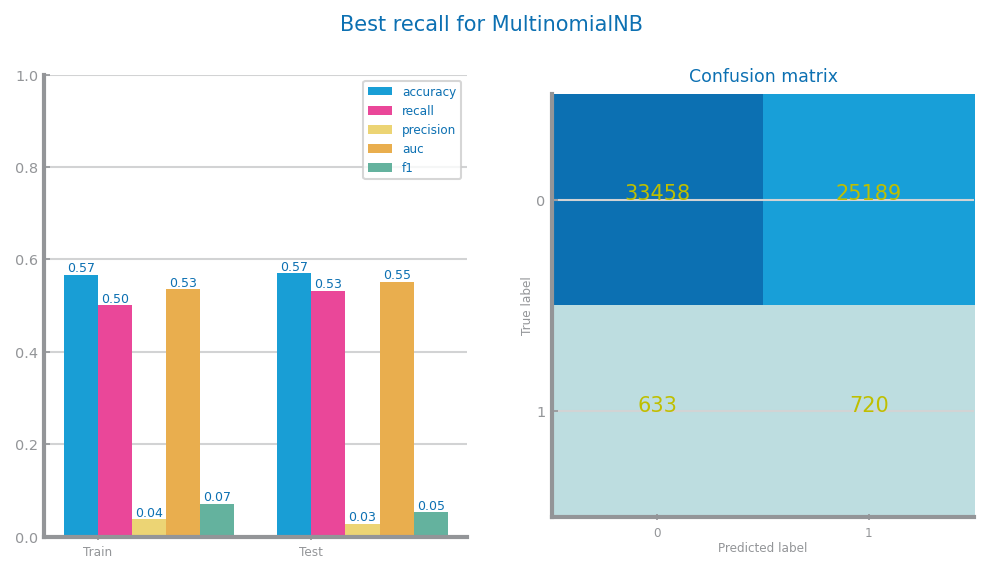

In [23]:
def naive_Bayes_study(
    trnX: ndarray, trnY: array, tstX: ndarray, tstY: array, metric: str = "accuracy"
) -> tuple:
    estimators: dict = {
        "GaussianNB": GaussianNB(),
        "MultinomialNB": MultinomialNB(),
        "BernoulliNB": BernoulliNB(),
    }

    xvalues: list[str] = []
    yvalues: list[float] = []
    best_model = None
    best_params: dict = {"name": "", "metric": metric, "params": ()}
    best_performance: float = 0.0

    for clf_name in estimators:
        xvalues.append(clf_name)
        clf = estimators[clf_name]
        clf.fit(trnX, trnY)
        prdY: array = clf.predict(tstX)
        eval_val: float = CLASS_EVAL_METRICS[metric](tstY, prdY)
        if eval_val - best_performance > DELTA_IMPROVE:
            best_performance = eval_val
            best_params["name"] = clf_name
            best_params[metric] = eval_val
            best_model = clf
        yvalues.append(eval_val)

    return best_model, best_params

# ---- NB study on OUTLIER-NONE dataset ----
figure()
best_nb_model, nb_params = naive_Bayes_study(trnX, trnY, tstX, tstY, metric=eval_metric)
savefig(f"../../charts/lab3_preparation/{file_tag}_nb_{eval_metric}_study.png")
show()

print("Best NB params:", nb_params)

# ---- NB confusion matrix + metrics ----
prd_trn_nb: array = best_nb_model.predict(trnX)
prd_tst_nb: array = best_nb_model.predict(tstX)

figure()
plot_evaluation_results(nb_params, trnY, prd_trn_nb, tstY, prd_tst_nb, labels)
savefig(f"../../charts/lab3_preparation/{file_tag}_nb_{nb_params['name']}_best_{nb_params['metric']}_eval.png")
show()


KNN best with k=3 and chebyshev (recall=0.0288)


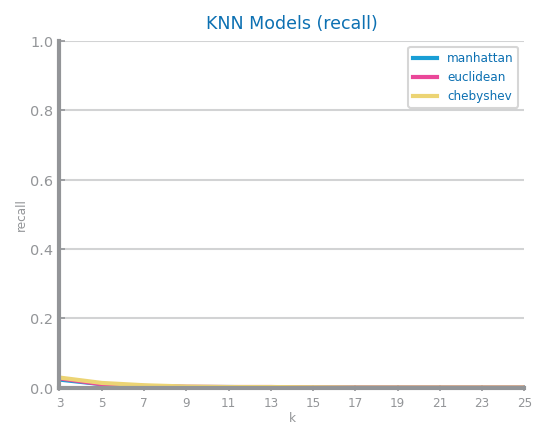

<Figure size 600x450 with 0 Axes>

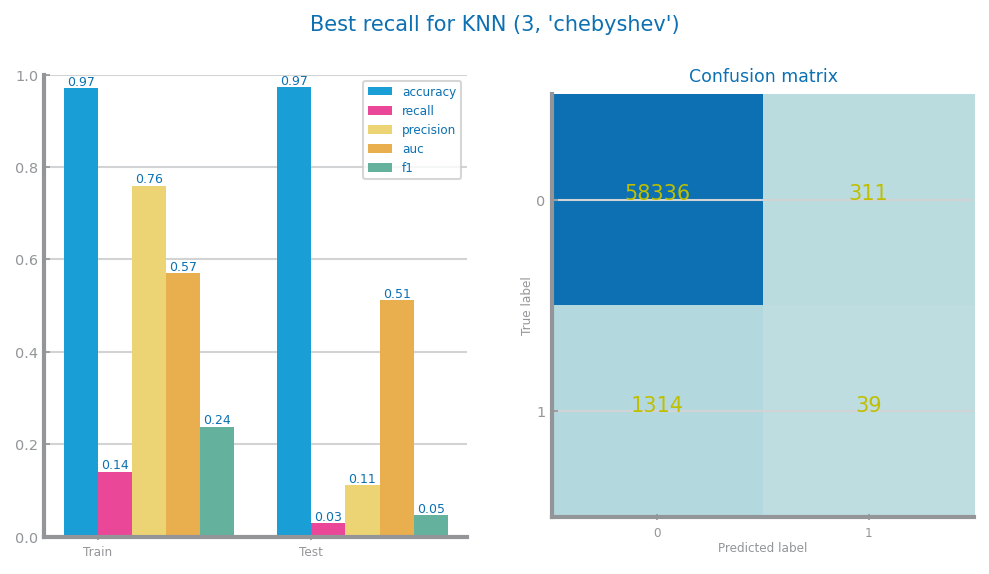

In [24]:
def knn_study(
    trnX: ndarray,
    trnY: array,
    tstX: ndarray,
    tstY: array,
    k_max: int = 10,
    lag: int = 2,
    metric: str = "recall",
    k_min: int = 3,
) -> tuple[KNeighborsClassifier | None, dict]:
    dist: list[Literal["manhattan", "euclidean", "chebyshev"]] = [
        "manhattan",
        "euclidean",
        "chebyshev",
    ]

    kvalues: list[int] = [k for k in range(k_min, k_max + 1, lag)]
    best_model: KNeighborsClassifier | None = None
    best_params: dict = {"name": "KNN", "metric": metric, "params": ()}
    best_performance: float = 0.0

    values: dict[str, list] = {}
    for d in dist:
        y_tst_values: list[float] = []
        for k in kvalues:
            clf = KNeighborsClassifier(n_neighbors=k, metric=d)
            clf.fit(trnX, trnY)
            prdY: array = clf.predict(tstX)
            eval_val: float = CLASS_EVAL_METRICS[metric](tstY, prdY)
            y_tst_values.append(eval_val)
            if eval_val - best_performance > DELTA_IMPROVE:
                best_performance = eval_val
                best_params["params"] = (k, d)
                best_model = clf
        values[d] = y_tst_values

    print(
        f'KNN best with k={best_params["params"][0]} and '
        f'{best_params["params"][1]} ({metric}={best_performance:.4f})'
    )

    plot_multiline_chart(
        kvalues,
        values,
        title=f"KNN Models ({metric})",
        xlabel="k",
        ylabel=metric,
        percentage=True,
    )

    return best_model, best_params

# ---- KNN param search + study plot on OUTLIER-NONE ----
figure()
best_knn, knn_params = knn_study(trnX, trnY, tstX, tstY, k_max=25, metric=eval_metric)
# savefig(f"../../charts/lab3_preparation/{file_tag}_knn_{eval_metric}_study.png")
# show()

# ---- KNN confusion matrix + metrics ----
prd_trn_knn = best_knn.predict(trnX)
prd_tst_knn = best_knn.predict(tstX)

figure()
plot_evaluation_results(
    knn_params,
    trnY,
    prd_trn_knn,
    tstY,
    prd_tst_knn,
    labels,
)
savefig(f"../../charts/lab3_preparation/{file_tag}_knn_{knn_params['name']}_best_{knn_params['metric']}_eval.png")
show()


# Saving Updated Data with Best Method

In [16]:
output_train_path = "../../data/prepared/outliers/flight_train_outliers.csv"
output_test_path  = "../../data/prepared/outliers/flight_test_outliers.csv"

print("Saving OUTLIERS-NONE train data to:", output_train_path)
print("Saving OUTLIERS-NONE test  data to:", output_test_path)

# NOTE: use train_none / test_none (not the *_eval versions that dropped FlightDate)
train_none.to_csv(output_train_path, index=False)
test_none.to_csv(output_test_path, index=False)

print("\nSaved NO-OUTLIER datasets:")
print("  Train →", output_train_path, "shape:", train_none.shape)
print("  Test  →", output_test_path,  "shape:", test_none.shape)

Saving OUTLIERS-NONE train data to: ../../data/prepared/outliers/flight_train_outliers.csv
Saving OUTLIERS-NONE test  data to: ../../data/prepared/outliers/flight_test_outliers.csv

Saved NO-OUTLIER datasets:
  Train → ../../data/prepared/outliers/flight_train_outliers.csv shape: (140000, 182)
  Test  → ../../data/prepared/outliers/flight_test_outliers.csv shape: (60000, 182)
